In [62]:
%matplotlib inline
from parcels import Field, FieldSet, ParticleSet,Variable, JITParticle, plotTrajectoriesFile, AdvectionRK4,ErrorCode
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, animation
import xarray as xr
from scipy.special import entr

from IPython.display import Image
rc('animation', html='html5')


In [63]:
def DeleteParticle(particle, fieldset, time):
    """Delete particle from OceanParcels simulation to avoid run failure
    """
    
    print(f'Particle {particle.id} lost !! [{particle.time}, {particle.depth}, {particle.lat}, {particle.lon}]')
    particle.delete()

In [64]:
class MPParticle(JITParticle):
    Kzf = Variable('Kzf', initial =  1.0) 
class MPParticle2(JITParticle):
    Kzf = Variable('Kzf', initial =  0.0) 

In [75]:
def tu_mix(particle,fieldset,time):
    bath= 160.02956
    if particle.depth+0.5 > bath: #Only calculate gradient of diffusion for particles deeper than 0.6 otherwise OP will check for particles outside the domain and remove it.
        Kzdz = 2*(fieldset.Kz[time,particle.depth,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth-0.5,particle.lat, particle.lon]) #forward difference 
    else: 
        Kzdz = 2*(fieldset.Kz[time,particle.depth+0.5,particle.lat, particle.lon]-fieldset.Kz[time,particle.depth,particle.lat, particle.lon]) #forward difference 
    dgrad = Kzdz * particle.dt * particle.Kzf
    if particle.depth+0.5*dgrad > 0:
        kk = fieldset.Kz[time,particle.depth+0.5*dgrad,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    else:
        kk = fieldset.Kz[time, 0,particle.lat, particle.lon] #Vertical diffusivity SSC  #
    Kx = 1.5
    Rr = ParcelsRandom.uniform(-1, 1)
    Rr2 = ParcelsRandom.uniform(-1, 1)
    d_random = sqrt(3*2*kk*particle.dt) * Rr
    d_randomx = sqrt(3*2*Kx*particle.dt) * Rr2
    Dlayerz = 0.5*sqrt(kk * particle.dt) #1m mixing layer
    Dlayerx = 0.5*sqrt(Kx * particle.dt)
    if particle.lon + d_randomx < 0:
        particle.lon = Dlayerx * ParcelsRandom.uniform(0, 1)
    elif particle.lon + d_randomx > 2e3:
        particle.lon = 2e3 - Dlayerx * ParcelsRandom.uniform(0, 1)
    else: 
        particle.lon=particle.lon + d_randomx
    if d_random + dgrad +particle.depth > bath: #randomly in the water column
        particle.depth = bath - Dlayerz * ParcelsRandom.uniform(0, 1)
    elif d_random +particle.depth +dgrad < 0:
            particle.depth = Dlayerz * ParcelsRandom.uniform(0, 1) #Well mixed boundary layer
    else:
        particle.depth += d_random + dgrad 

In [76]:
Dat = pd.read_csv('/ocean/mattmiller/MOAD/analysis-matt/files/ubcSSg3DwGridFields1hV19-05_b948_4a17_3c99.csv')
depth=np.array(Dat.depth)[1:].astype('float32')
Kz_col=np.array(Dat.vert_eddy_diff)[1:].astype('float32')

In [77]:
dim = 100
dep = len(depth)
lon = np.linspace(0., 2e3, dim, dtype=np.float32)
dep2= np.linspace(0., depth[-1], dim, dtype=np.float32)
#lon_g, depth_g = np.meshgrid(lon,dep2)
U = Field('U', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
V = Field('V', np.zeros((dep, dim), dtype=np.float32), lon=lon, depth=depth)
Kz_data = np.zeros((dep, dim), dtype=np.float32)
for i in range(dim):
    Kz_data[:,i]=Kz_col
Kz = Field('Kz', Kz_data, grid=U.grid)

In [78]:
fieldset = FieldSet(U, V)
fieldset.add_field(Kz)

In [79]:
lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))
lat_g = np.zeros(10*dim,)

In [80]:
def run_turb_test(lon_g,depth_g):
    pset = ParticleSet(fieldset, pclass=MPParticle, lon=lon_g, lat=lat_g, depth=depth_g)
    pset2 = ParticleSet(fieldset, pclass=MPParticle2, lon=lon_g, lat=lat_g, depth=depth_g)
    output_file = pset.ParticleFile(name='/ocean/mattmiller/MOAD/results/parcels/test/Output.zarr', outputdt=50)
    output_file2 = pset2.ParticleFile(name='/ocean/mattmiller/MOAD/results/parcels/test/Output2.zarr', outputdt=50)
    KE=tu_mix
    pset.execute(KE , runtime=5e3, dt=5, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})
    pset2.execute(KE , runtime=5e3, dt=5, output_file=output_file2,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

In [81]:
run_turb_test(lon_g,depth_g)

INFO: Compiled ArrayMPParticletu_mix ==> /tmp/parcels-2928/lib71aafce724953e665963ec5894755202_0.so


Particle 16038 lost !! [40.0, 160.0246124267578, 0.0, 1597.6756591796875]
Particle 16374 lost !! [5.0, 160.0207977294922, 0.0, 391.583984375]
Particle 16385 lost !! [15.0, 160.0257110595703, 0.0, 1595.6820068359375]
Particle 16562 lost !! [90.0, 160.02059936523438, 0.0, 438.8281555175781]
Particle 16808 lost !! [120.0, 160.02328491210938, 0.0, 1705.0537109375]
Particle 16048 lost !! [155.0, 160.0265350341797, 0.0, 1101.7340087890625]
Particle 16338 lost !! [190.0, 160.0193634033203, 0.0, 529.3599243164062]
Particle 16526 lost !! [190.0, 160.0245361328125, 0.0, 1580.7301025390625]
Particle 16712 lost !! [175.0, 160.0194549560547, 0.0, 908.5006713867188]
Particle 16530 lost !! [210.0, 160.02011108398438, 0.0, 262.5514831542969]
Particle 16849 lost !! [225.0, 160.02804565429688, 0.0, 723.0914916992188]
Particle 16777 lost !! [255.0, 160.025634765625, 0.0, 1813.691162109375]
Particle 16054 lost !! [330.0, 160.02407836914062, 0.0, 1389.5234375]
Particle 16343 lost !! [330.0, 160.02091979980

INFO: Output files are stored in /ocean/mattmiller/MOAD/results/parcels/test/Output.zarr.
  0%|          | 0/5000.0 [00:00<?, ?it/s]

Particle 16444 lost !! [2255.0, 160.02919006347656, 0.0, 1013.9126586914062]


 46%|████▌     | 2300.0/5000.0 [00:00<00:00, 9329.20it/s]

Particle 16042 lost !! [2380.0, 160.01918029785156, 0.0, 313.1861267089844]
Particle 16409 lost !! [2495.0, 160.02232360839844, 0.0, 1704.385498046875]
Particle 16499 lost !! [2490.0, 160.0249786376953, 0.0, 1811.7784423828125]
Particle 16654 lost !! [2485.0, 160.0293426513672, 0.0, 477.2748718261719]
Particle 16225 lost !! [2580.0, 160.0258026123047, 0.0, 1492.3873291015625]
Particle 16946 lost !! [2585.0, 160.02281188964844, 0.0, 1011.27197265625]
Particle 16886 lost !! [2645.0, 160.020751953125, 0.0, 337.1946105957031]
Particle 16664 lost !! [2830.0, 160.01853942871094, 0.0, 151.0372772216797]
Particle 16844 lost !! [2870.0, 160.0269775390625, 0.0, 339.83489990234375]
Particle 16000 lost !! [2995.0, 160.02464294433594, 0.0, 792.9243774414062]
Particle 16082 lost !! [2970.0, 160.02276611328125, 0.0, 932.5868530273438]
Particle 16093 lost !! [2975.0, 160.0250701904297, 0.0, 1328.9080810546875]
Particle 16494 lost !! [2975.0, 160.01754760742188, 0.0, 1073.096435546875]
Particle 16962 l

 65%|██████▌   | 3250.0/5000.0 [00:04<00:02, 588.03it/s] 

Particle 16600 lost !! [3200.0, 160.028076171875, 0.0, 311.03875732421875]
Particle 16765 lost !! [3210.0, 160.02418518066406, 0.0, 1183.1925048828125]
Particle 16871 lost !! [3325.0, 160.02919006347656, 0.0, 258.34320068359375]
Particle 16756 lost !! [3370.0, 160.0243682861328, 0.0, 1050.6370849609375]
Particle 16948 lost !! [3395.0, 160.0272216796875, 0.0, 75.69072723388672]
Particle 16988 lost !! [3350.0, 160.02001953125, 0.0, 900.6343994140625]
Particle 16055 lost !! [3445.0, 160.01913452148438, 0.0, 332.2852478027344]
Particle 16201 lost !! [3405.0, 160.02493286132812, 0.0, 1883.4818115234375]
Particle 16909 lost !! [3465.0, 160.02220153808594, 0.0, 1152.331298828125]
Particle 16215 lost !! [3575.0, 160.02476501464844, 0.0, 1703.95703125]
Particle 16491 lost !! [3560.0, 160.0210418701172, 0.0, 803.6555786132812]
Particle 16775 lost !! [3580.0, 160.02767944335938, 0.0, 1282.2064208984375]
Particle 16791 lost !! [3590.0, 160.0225830078125, 0.0, 1387.6636962890625]
Particle 16563 los

 73%|███████▎  | 3650.0/5000.0 [00:06<00:03, 443.53it/s]

Particle 16656 lost !! [3725.0, 160.02928161621094, 0.0, 562.8428955078125]
Particle 16836 lost !! [3715.0, 160.02359008789062, 0.0, 1648.0224609375]
Particle 16284 lost !! [3855.0, 160.02259826660156, 0.0, 225.44876098632812]


 78%|███████▊  | 3900.0/5000.0 [00:07<00:02, 398.80it/s]

Particle 16440 lost !! [3935.0, 160.02610778808594, 0.0, 898.5027465820312]
Particle 16528 lost !! [3935.0, 160.02671813964844, 0.0, 1061.2169189453125]
Particle 16514 lost !! [4040.0, 160.02450561523438, 0.0, 576.1460571289062]


 81%|████████  | 4050.0/5000.0 [00:08<00:02, 366.33it/s]

Particle 16415 lost !! [4050.0, 160.0265350341797, 0.0, 1422.0238037109375]
Particle 16963 lost !! [4065.0, 160.0225067138672, 0.0, 1619.2857666015625]
Particle 16478 lost !! [4100.0, 160.0220184326172, 0.0, 1207.7086181640625]
Particle 16663 lost !! [4100.0, 160.01968383789062, 0.0, 1212.048095703125]


 86%|████████▌ | 4300.0/5000.0 [00:09<00:02, 305.10it/s]

Particle 16298 lost !! [4320.0, 160.0256805419922, 0.0, 1484.14990234375]
Particle 16789 lost !! [4330.0, 160.02005004882812, 0.0, 1004.5120849609375]
Particle 16920 lost !! [4335.0, 160.02554321289062, 0.0, 1902.3480224609375]


 89%|████████▉ | 4450.0/5000.0 [00:09<00:01, 285.70it/s]

Particle 16149 lost !! [4485.0, 160.01866149902344, 0.0, 393.0886535644531]
Particle 16354 lost !! [4460.0, 160.02896118164062, 0.0, 1587.659423828125]
Particle 16418 lost !! [4475.0, 160.02099609375, 0.0, 120.8634033203125]


 90%|█████████ | 4500.0/5000.0 [00:10<00:01, 275.25it/s]

Particle 16099 lost !! [4500.0, 160.02284240722656, 0.0, 522.8385620117188]
Particle 16166 lost !! [4515.0, 160.0260772705078, 0.0, 1262.654296875]
Particle 16481 lost !! [4515.0, 160.02952575683594, 0.0, 136.9066619873047]


 93%|█████████▎| 4650.0/5000.0 [00:10<00:01, 261.78it/s]

Particle 16646 lost !! [4695.0, 160.0257110595703, 0.0, 1957.9510498046875]
Particle 16856 lost !! [4665.0, 160.0198211669922, 0.0, 883.8502197265625]


 94%|█████████▍| 4700.0/5000.0 [00:11<00:01, 248.18it/s]

Particle 16294 lost !! [4730.0, 160.0245819091797, 0.0, 799.93017578125]


 95%|█████████▌| 4750.0/5000.0 [00:11<00:01, 239.79it/s]

Particle 16160 lost !! [4780.0, 160.02059936523438, 0.0, 1417.873291015625]


 97%|█████████▋| 4850.0/5000.0 [00:11<00:00, 236.92it/s]

Particle 16995 lost !! [4855.0, 160.02447509765625, 0.0, 855.8770751953125]


 98%|█████████▊| 4900.0/5000.0 [00:12<00:00, 179.05it/s]

Particle 16043 lost !! [4930.0, 160.0219268798828, 0.0, 1719.892822265625]


100%|██████████| 5000.0/5000.0 [00:12<00:00, 394.69it/s]
INFO: Compiled ArrayMPParticle2tu_mix ==> /tmp/parcels-2928/lib35955d351265a3a225de57b78d3c5ecb_0.so
INFO: Output files are stored in /ocean/mattmiller/MOAD/results/parcels/test/Output2.zarr.
100%|██████████| 5000.0/5000.0 [00:10<00:00, 458.02it/s]  


In [82]:
dat = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Output.zarr')
dat2 = xr.load_dataset('/ocean/mattmiller/MOAD/results/parcels/test/Output2.zarr')

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [83]:
def anim2(file1,file2,fps=1):  
    box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,4,figsize=(15,10))
    axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
    axs[3].plot(Kz_col,depth,c='r')
    axs[3].set_title('Vertical profile $K_z$ [$m^2/s$]')
    axs[3].invert_yaxis()
    axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    axs[1].plot(box[0],box[1],c='grey',linewidth=3)
    axs[2].plot(box[0],box[1],c='grey',linewidth=3)
    axs[0].invert_yaxis()
    axs[0].set_title('Initial condition (t: 0s)')
    axs[1].invert_yaxis()
    axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
    axs[2].invert_yaxis()
    axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
    axs[0].set_ylabel('Depth (m)')

    def update(frame):           
        global ss        
        for scat in ss:              
            scat.remove()            
        ss =[]                    
        ss.append(axs[1].scatter(file1.lon[:,frame],file1.z[:,frame],s=5,c ='tab:blue'))         
        ss.append(axs[2].scatter(file2.lon[:,frame],file2.z[:,frame],s=5,c ='tab:blue'))                      
        print(f'{frame/len(file1):.2f}% completed')           
        return ss
    return animation.FuncAnimation(fig, update, frames=np.arange(0,100,fps))

0.00% completed
0.00% completed
0.20% completed
0.40% completed
0.60% completed
0.80% completed
1.00% completed
1.20% completed
1.40% completed
1.60% completed
1.80% completed
2.00% completed
2.20% completed
2.40% completed
2.60% completed
2.80% completed
3.00% completed
3.20% completed
3.40% completed
3.60% completed
3.80% completed
4.00% completed
4.20% completed
4.40% completed
4.60% completed
4.80% completed
5.00% completed
5.20% completed
5.40% completed
5.60% completed
5.80% completed
6.00% completed
6.20% completed
6.40% completed
6.60% completed
6.80% completed
7.00% completed
7.20% completed
7.40% completed
7.60% completed
7.80% completed
8.00% completed
8.20% completed
8.40% completed
8.60% completed
8.80% completed
9.00% completed
9.20% completed
9.40% completed
9.60% completed
9.80% completed
10.00% completed
10.20% completed
10.40% completed
10.60% completed
10.80% completed
11.00% completed
11.20% completed
11.40% completed
11.60% completed
11.80% completed
12.00% complet

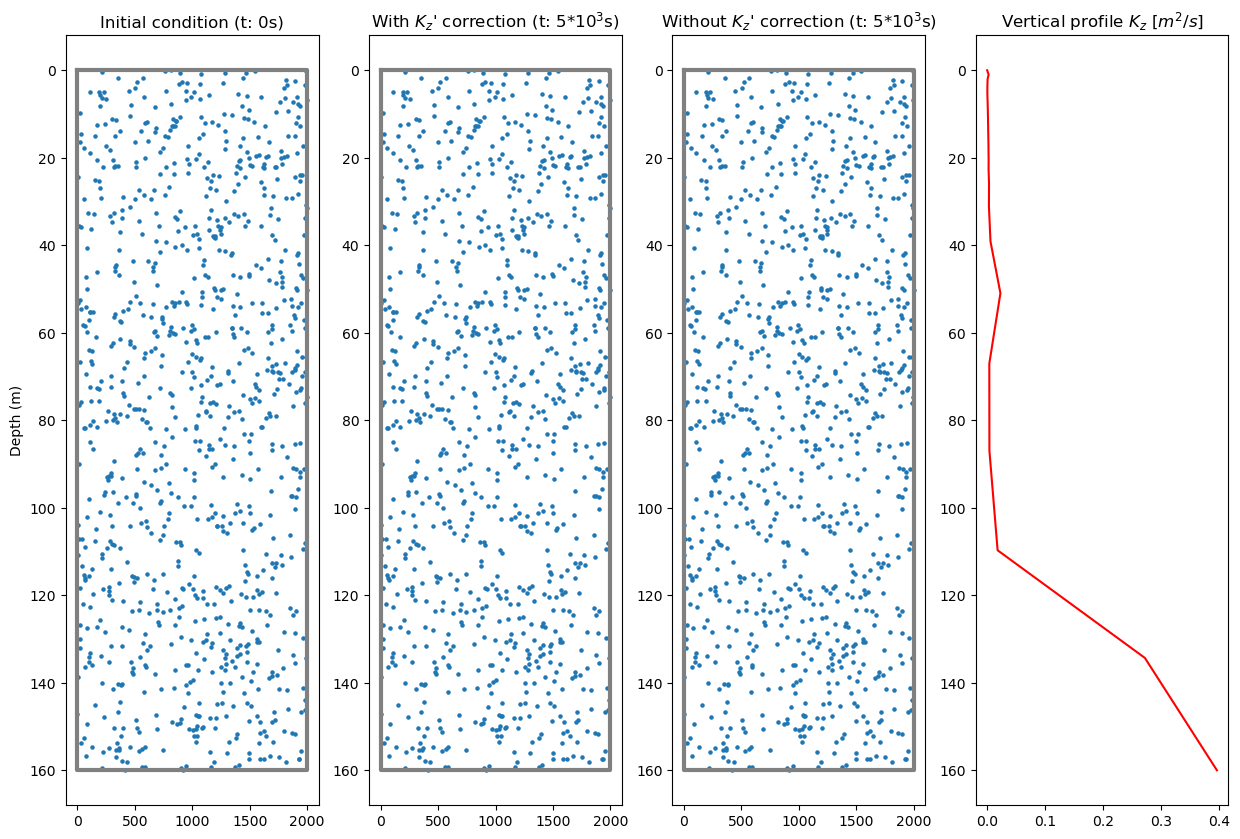

In [84]:
ss =[]
ani = anim2(dat,dat2,fps=1)
f = r'/ocean/mattmiller/MOAD/results/parcels/test/mix.gif'
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

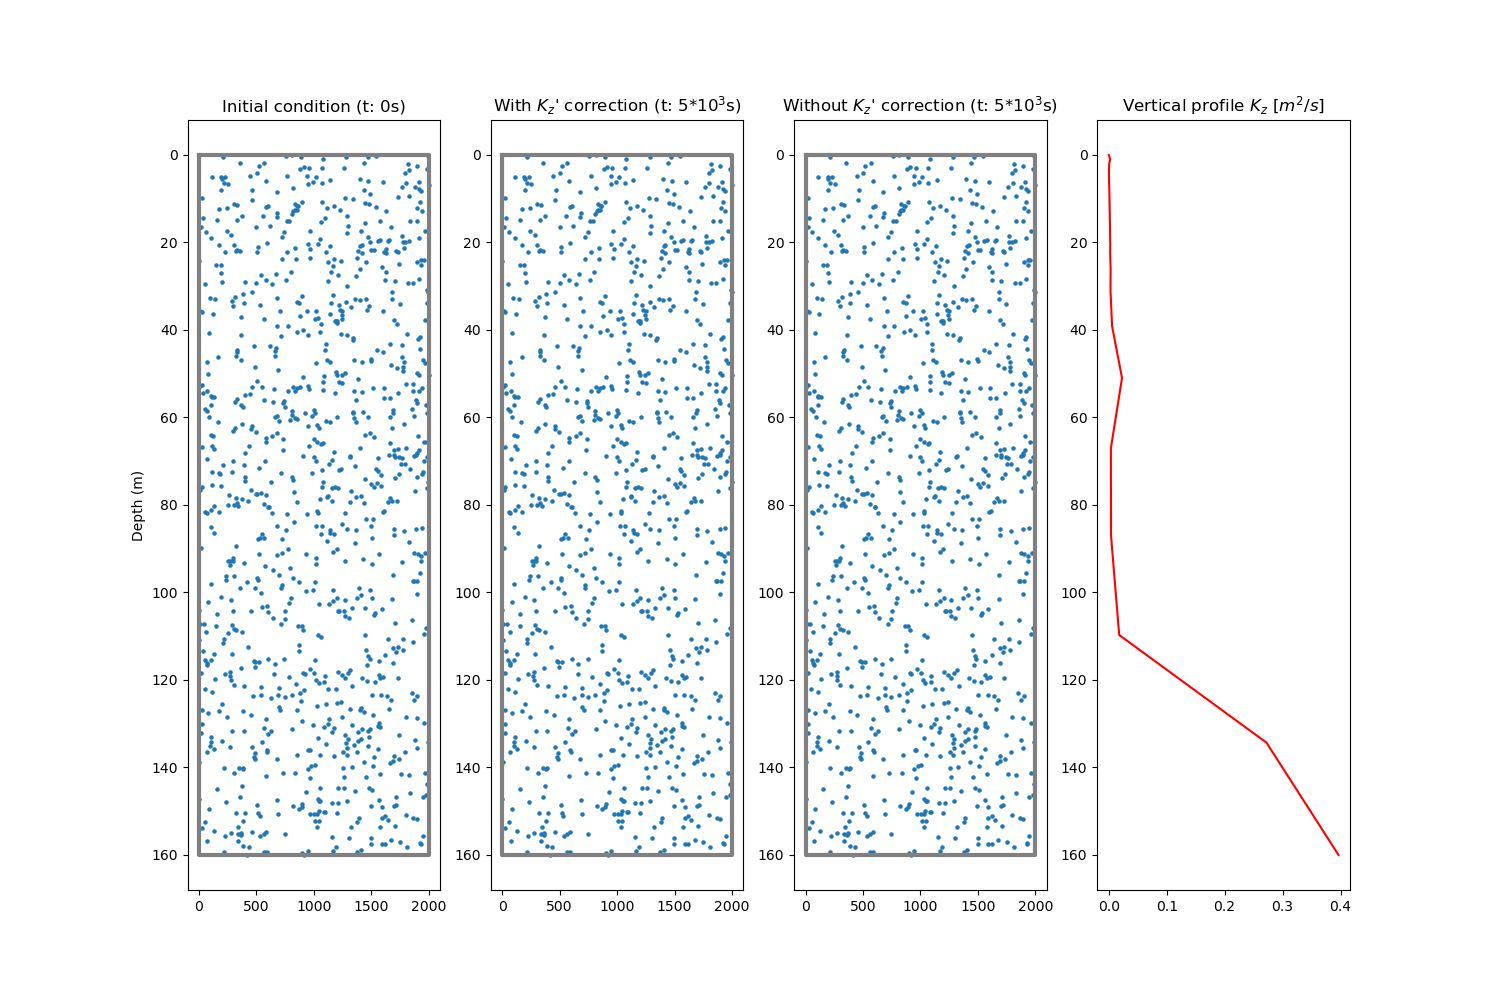

In [85]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

Text(0, 0.5, 'Depth (m)')

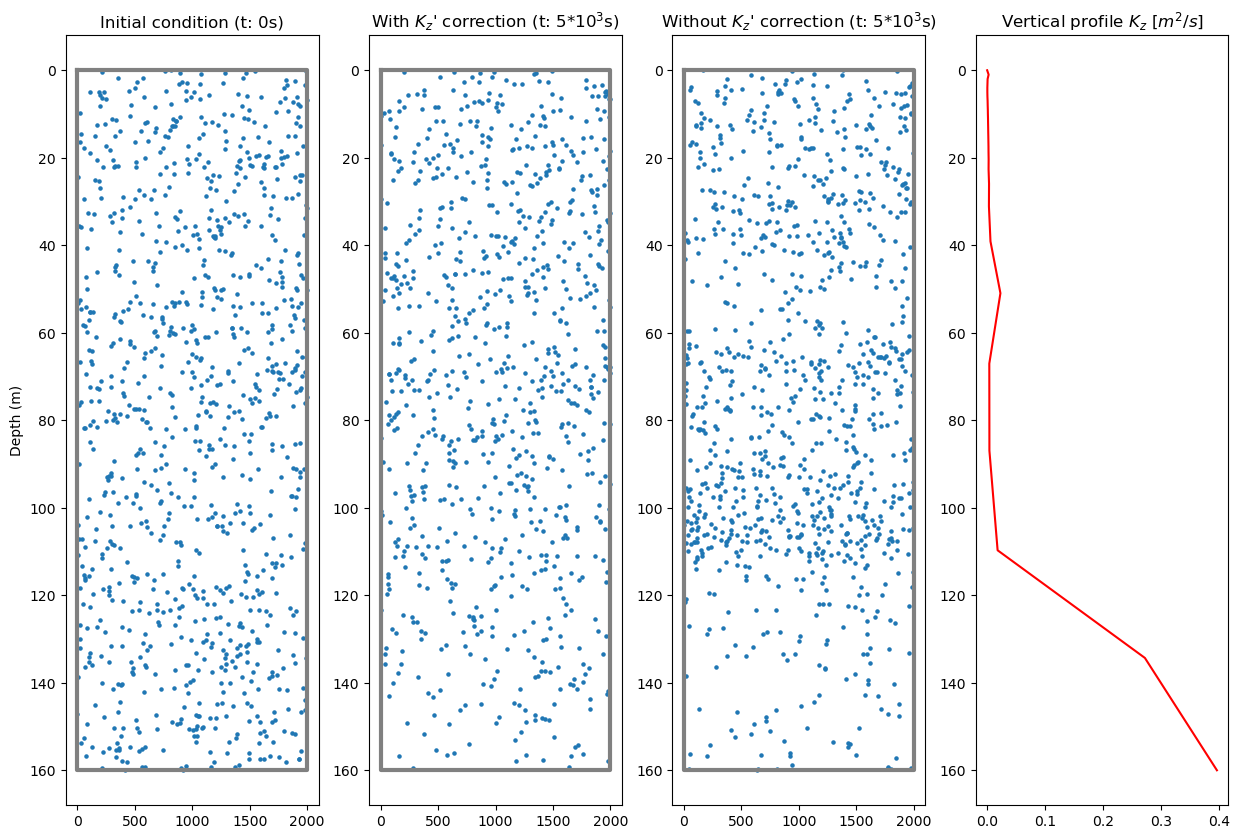

In [86]:
box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
fig,axs=plt.subplots(1,4,figsize=(15,10))
axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
#ax2 = axs[2].twiny()
#ax2.plot(Kz_col,depth,c='r')
axs[3].plot(Kz_col,depth,c='r')
axs[3].set_title('Vertical profile $K_z$ [$m^2/s$]')
axs[3].invert_yaxis()
axs[0].plot(box[0],box[1],c='grey',linewidth=3)
axs[1].plot(box[0],box[1],c='grey',linewidth=3)
axs[2].plot(box[0],box[1],c='grey',linewidth=3)
axs[0].invert_yaxis()
axs[0].set_title('Initial condition (t: 0s)')
axs[1].scatter(dat.lon[:,-1],dat.z[:,-1],s=5)
axs[1].invert_yaxis()
axs[1].set_title("With $K_z$' correction (t: 5*$10^3$s)")
axs[2].scatter(dat2.lon[:,-1],dat2.z[:,-1],s=5)
axs[2].invert_yaxis()
axs[2].set_title("Without $K_z$' correction (t: 5*$10^3$s)")
axs[0].set_ylabel('Depth (m)')

In [ ]:
def entropy(data, bins=100):
    """
        Calculate entropy of multiple varibles (discrete and continous).
        X is a 2d-array, each column is a variable.
    """
    hist = np.histogramdd(data, bins=bins)[0]
    prob = hist/len(data)
    prob[prob == 0] = 1
    log_prob = np.log2(prob)
    

    return -np.sum(np.multiply(prob, log_prob))

In [ ]:
def no_nan(x,y):
    no_nan=[]
    no_nan1=[]
    for i,xi in enumerate(x):
        if np.isnan(xi) == False:
            no_nan.append(xi) 
            no_nan1.append(y[i]) 
    return no_nan,no_nan1

d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
e0=entropy([d0,l0])

In [ ]:
import sys, os

# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

In [ ]:
def run_n_test(n):
    e1,e2=[],[]
    for i in range(n):
        lon_g = np.random.uniform(low=lon[0], high=lon[-1], size=(10*dim,))
        depth_g = np.random.uniform(low=depth[0], high=depth[-1], size=(10*dim,))
        run_turb_test(lon_g,depth_g)
        dat = xr.load_dataset('Output.nc')
        dat2 = xr.load_dataset('Output2.nc')
        d0,l0=no_nan(dat2.lat[:,0],dat2.lon[:,0])
        e0=entropy([d0,l0])
        d2,l2=no_nan(dat2.lat[:,-1],dat2.lon[:,-1])
        e2.append(entropy([d2,l2])-e0)
        d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
        e1.append(entropy([d1,l1])-e0)
    m1=np.mean(e1)
    sd1=np.std(e1)/np.sqrt(n)
    m2=np.mean(e2)
    sd2=np.std(e2)/np.sqrt(n)
    return m1,sd1,m2,sd2

In [ ]:
blockPrint()
m1,sd1,m2,sd2=run_n_test(10)
enablePrint()

CTEs = [m1, m2]
error = [sd1, sd2]

In [ ]:
# Build the plot
x_pos=np.arange(2)
fig, ax = plt.subplots(figsize=(8,8))
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Entropy difference')
ax.set_xticks(x_pos)
ax.set_xticklabels(["With Kz' correction","Without Kz' correction"])
ax.set_title('Entropy difference vs initial random distribution')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()

In [ ]:
d2,l2=no_nan(dat2.lat[:,-1],dat2.lon[:,-1])
entropy([d2,l2])-e0

In [ ]:
d1,l1=no_nan(dat.lat[:,-1],dat.lon[:,-1])
entropy([d1,l1])-e0